# RNN

## Overview

1. Choose a `language model` that will best represent the input text.
2. Clean and prepare the data for training.
3. Build a basic Keras sequential neural network model.
4. Apply `recurrent neural network (RNN)` to process character sequences.
5. Generate 3 channel RGB color outputs.

![RGB Values](./res/rnn_modeling.png)

## Language Model

There are two general options for language modeling: word-level models and character-level models. Each has its advantages and disadvatanges. Let's go through them now.

## Word-Level Language Model

The word-level language model can handle relatively long and clean sentences. By "clean", I mean the words in the text datasets are free from typos and have few words outside of English vocabulary. The word-level language model encodes each unique word into a corresponding integer, and there's a predefined fixed-sized vocabulary dictionary to look up the word to integer mapping.

One major benefit of the word-level language model is its ability to leverage pre-trained word embeddings such as **Word2Vec** and **GloVe**. These embeddings represesnt words as vectors with useful properties. Words close in context are close in Euclidean distance and can be used to understand analogies like "man is to women, as king is to queen". Using these ideas, you can train a word-level model with relatively small labeled training sets.

## Character-Level Language Model

But there's an even simpler language model, one that splits a text string into characters and associates a unique integer to every single character. There are some reasons you might choose to use the character-level language model over the more popular word-level model:
- Your text datasets contain a noticeable amount of out-of-vocabulary words or infrequent words. In our case, some legitimate color names could be :aquatone", "chartreuse", and "fuchsia". For me, I have to check a dictionary to find out their meanings, and traditional word-level embeddings may not contain them.
- The majority of the text strings are short, bounded-length strings. If you're looking for a specific length limit, I've been dealing with a _Yelp_ review generation model with character level encode character length of 60 and still get decent results. Usually, character-level language model can create text with more variety since its imagination is not constrained by a pre-defined dictionary of vocabulary.

You may also be aware of the limitation that came with adopting character-level language:
- Long seqences may not capture long-range dependencies as well as word-level language models.
- Character-level models are also more computationally expensive to train.
- Given the same datasets, these model sequences are longer and, as a result, require extended training time.

Fotunately, these limitations won't pose a threat to our color generation task. We're limiting our color names to 25 characters in length and we only have 18,606 training samples.

> *_NOTE_*: This number differs from the dataset we will be using today.

In [2]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape
from tensorflow.python.keras.utils import np_utils

import numpy as np
import pandas as pd
import scipy.stats as stats
import pylab as plt

In [3]:
data = pd.read_csv('./res/data/colors.csv')
names = data['name']
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


## Data Preparation

We mentioned that we're limiting our color names to 25 characters. To arrive at this number, we checked the distribution of the length of color names across all training samples and visualized it to make sure the length limit we pick makes sense.

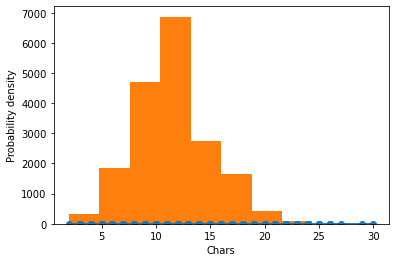

In [4]:
h = sorted(names.str.len().values)

fit = stats.norm.pdf(h, np.mean(h), np.std(h))
plt.plot(h, fit, '-o')
plt.hist(h)
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

You can clearly see tha the majority of the color name strings have lengths less or equal to 25, even though the max length goes up to 30. We could pick the max length of 30, but the model we're going to build would also need to be trained on longer sequences for an extended time. Our trade-off to pick shorter sequence length reduces the model training complexity while not compromising the integrity of the training data.

With the decision of the max length made, the next step in the character-level data pre-processing is to transform each color name string to a list of 25 integer values, and this is made easy with the Keras text tokenization utility.

In [5]:
maxlen = 25
token = Tokenizer(char_level=True)
token.fit_on_texts(names)
tokenized = token.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
print(padded_names.shape)

(18606, 25)


18,606 is the number of total training samples and 25 being the max sequence length. If a strin has less than 25 characters, it will be padded with the value 0 from the beginning of the sequence.

All inputs are now in the formof integers, and our model should be able to process it. However, there is one more step we can take to make later model training more effective.

## One-Hot Encoding

We can view the character-to-integer mapping by inspecting the `token.word_index` property of the instance of Keras' Tokenizer.

In [6]:
print(token.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


We can see that all of the most frequent characters (letters) are in the top 25. Therefore, this number should be sufficient.

However, the integer values have no natural ordered relationship between each other and our model may not be able to harness any benefit from it. What's worse, our model will initially assume such an ordering relationship among those characters (i.e. `a` is 2 and `e` is 1, but this should not signify a relationship), which can lead to an unwanted result. We will use **one-hot-encoding** to represent the input sequence.

Each integer will be represented by a boolean array where only one element in the array will have a value of 1. The max integer value will determine the length of the boolean array in the character dictionary. In our case, the max integer value is `u : 89`, so the length of a one-hot boolean array with be 28.

In [7]:
one_hot_names = np_utils.to_categorical(padded_names)

In [8]:
# the shape is (number of training samples, max sequence length, number of unique tokens)
one_hot_names.shape

(18606, 25, 90)

## Data Normalization

Remember that we're predicitng 3 color channel values, each value ranging between 0-255. There is no golden rule for data normalization. It is practical here to minimize the computational expense for our model to converge if the traning data values are too spread out.

A common normalization technique is to scale values to [-1,1]. In our model, we're using `ReLU` activation functino in the last layer. Since `ReLU` outputs non-negative numbers, our model will be normalized to [0,-1] instead.

In [9]:
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([
    norm(data['red']),
    norm(data['green']),
    norm(data['blue'])
])

## Building the Model

To build our model, we're going to use two types of neural networks: a feed-forward neural network and a recurrent neural network. The feed-forward neural network is by far the most common type of neural network. Here, the information comes into the input units and flows in one direction through hidden layers until each reaches the output units.

In recurrent neural networks, information can flow around in cycles. These networks can remember information for a long time. They are a very natural way to model sequential data. In our specific model, we're using one of the most powerful recurrent networks, `long short-term memory` (LSTM).

The easiest way to build a deep learnign model in Keras is to use its Sequential API, and we simply connect each of the neural network layers by calling its `model.add()` function.

In [10]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [11]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

2022-05-29 20:29:34.009063: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
466/466 [==============================] - 59s 124ms/step - loss: 0.0684 - acc: 0.5800 - val_loss: 0.0633 - val_acc: 0.6161
Epoch 2/50
466/466 [==============================] - 63s 134ms/step - loss: 0.0640 - acc: 0.6232 - val_loss: 0.0607 - val_acc: 0.6239
Epoch 3/50
466/466 [==============================] - 64s 137ms/step - loss: 0.0613 - acc: 0.6317 - val_loss: 0.0598 - val_acc: 0.6308
Epoch 4/50
466/466 [==============================] - 63s 136ms/step - loss: 0.0590 - acc: 0.6426 - val_loss: 0.0576 - val_acc: 0.6212
Epoch 5/50
466/466 [==============================] - 63s 136ms/step - loss: 0.0567 - acc: 0.6342 - val_loss: 0.0567 - val_acc: 0.5932
Epoch 6/50
466/466 [==============================] - 64s 138ms/step - loss: 0.0546 - acc: 0.6393 - val_loss: 0.0569 - val_acc: 0.6024
Epoch 7/50
466/466 [==============================] - 65s 138ms/step - loss: 0.0525 - acc: 0.6414 - val_loss: 0.0562 - val_acc: 0.5868
Epoch 8/50
466/466 [==============================] - 6

## Generate Colors

For a color name inpout, we need to transform it into the same on-hot representation. To achieve this, tokenize characters to integers with the same tokenizer with which we processed the training data, pad it to the max sequence length of 25, then apply the one-hot encoding to the integer sequence.

And for the output RGB values, we need to scale it back to the 255-base so we can display them correctly.

In [16]:
# plot a color image
def plot_rgb(rgb):
    data =[[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255)

def predict(name):
    name = name.lower()
    tokenized = token.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    r,g,b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B', r,g,b)
    plot_rgb(pred)

forest, R,G,B 19 68 25


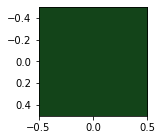

In [17]:
predict('forest')

ocean, R,G,B 8 70 146


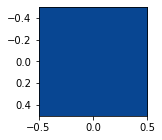

In [18]:
predict('ocean')

torqoise, R,G,B 143 185 118


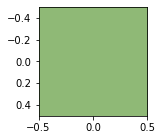

In [19]:
predict('torqoise')

light green, R,G,B 88 246 129


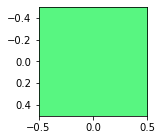

In [20]:
predict('light green')

velvet, R,G,B 33 59 68


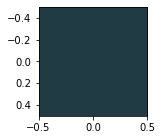

In [21]:
predict('velvet')

car, R,G,B 20 40 98


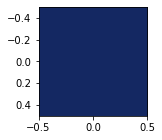

In [22]:
predict('car')

tv, R,G,B 168 146 142


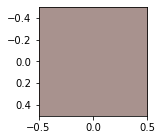

In [23]:
predict('tv')

## Summary

![Pipeline](./res/pipeline.png)